In [24]:
# Import Libraries and Dependencies
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import requests
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Global Init Variables
GET_WEATHER = False # Flag to control weather data retrieval

1) Data Loading and Initial Processing

In [25]:
# Read and clean observations data from iNaturalist
observations_df = pd.read_csv('observations.csv')
observations_df = observations_df.dropna() # Drop rows with missing values

# Display initial data overview
print("Initial Data Overview:")
print("=====================")
observations_df.head()

Initial Data Overview:


,id,date_string,coordinates,PowderyMildew,longitude,latitude,year,month,day
0,48688154,2020-06-06T14:17:01-04:00,"[-73.9520673641, 40.7700205967]",True,-73.952067,40.770021,2020,6,6
1,116476822,2022-05-10T16:37:09-04:00,"[-73.95191313710001, 40.7701800205]",True,-73.951913,40.770180,2022,5,10
2,169576529,2023-06-26T09:10:01+02:00,"[8.80802725, 50.8119201389]",True,8.808027,50.811920,2023,6,26
3,206356226,2024-04-09T19:08:00-04:00,"[-76.3073433611, 38.9860498889]",True,-76.307343,38.986050,2024,4,9
4,162498461,2023-05-19T16:44:24+02:00,"[12.9216153547, 48.6943073404]",True,12.921615,48.694307,2023,5,19


2. Parse Datetime into relevant features

In [26]:
# Function to parse date_string and extract year/month/day
def extract_date_components(date_string):
    import datetime
    # Parse ISO format date string
    dt = datetime.datetime.fromisoformat(date_string.replace('Z', '+00:00'))
    return dt.year, dt.month, dt.day

# Extract relevant data for true observations
lons = []
lats = []
years = []
months = []
days = []

for _, row in observations_df.iterrows():
    # Parse the coordinates string into a list of floats
    coords = eval(row['coordinates'])
    lons.append(coords[0])
    lats.append(coords[1])
    
    # Extract the date components from the date_string
    year, month, day = extract_date_components(row['date_string'])
    years.append(year)
    months.append(month)
    days.append(day)
    
# Apply parsed data to the observations_df
observations_df['longitude'] = lons
observations_df['latitude'] = lats
observations_df['year'] = years
observations_df['month'] = months
observations_df['day'] = days

# Calculate day of year from year, month, and day
observations_df['day_of_year'] = observations_df.apply(
    lambda row: datetime.datetime(row['year'], row['month'], row['day']).timetuple().tm_yday, 
    axis=1
)

# Display updated data overview
print("Updated Data Overview:")
print("=====================")
observations_df.head()


Updated Data Overview:


,id,date_string,coordinates,PowderyMildew,longitude,latitude,year,month,day,day_of_year
0,48688154,2020-06-06T14:17:01-04:00,"[-73.9520673641, 40.7700205967]",True,-73.952067,40.770021,2020,6,6,158
1,116476822,2022-05-10T16:37:09-04:00,"[-73.95191313710001, 40.7701800205]",True,-73.951913,40.770180,2022,5,10,130
2,169576529,2023-06-26T09:10:01+02:00,"[8.80802725, 50.8119201389]",True,8.808027,50.811920,2023,6,26,177
3,206356226,2024-04-09T19:08:00-04:00,"[-76.3073433611, 38.9860498889]",True,-76.307343,38.986050,2024,4,9,100
4,162498461,2023-05-19T16:44:24+02:00,"[12.9216153547, 48.6943073404]",True,12.921615,48.694307,2023,5,19,139


3. Gather Historical Training Data from NASA POWER DAV API

In [27]:
def get_general_weather(lon, lat, day, month, year, param_list):
    """
    Get NASA weather data at given coordinates for specified date range.
    Right now we are using the prior 3 weeks (21 days) for each point.
    
    Parameters:
        lon (float): Longitude coordinate
        lat (float): Latitude coordinate
        day (int): Day of the month
        month (int): Month of the year
        year (int): Year
        param_list (list): List of weather parameters to retrieve
    
    Returns:
        dict: Dictionary containing requested weather parameters and values
    """
    url = "https://power.larc.nasa.gov/api/temporal/hourly/point"
    
    month_str = str(month).zfill(2)
    day_str = str(day).zfill(2)
    start_date = f"{year}-{month_str}-{day_str}"
    
    start_date = datetime.datetime.strptime(start_date, "%Y-%m-%d") 
    end_date = start_date
    start_date -= datetime.timedelta(days=21)
    
    start_date = start_date.strftime("%Y%m%d")
    end_date = end_date.strftime("%Y%m%d")
    
    parameters = {
        "parameters": ",".join(param_list),
        "community": "AG",
        "latitude": lat,
        "longitude": lon,
        "start": start_date,
        "end": end_date,
        "format": "JSON"
    }
    
    try:
        response = requests.get(url, params=parameters)
        data = response.json()
        curr_data = {param: data['properties']['parameter'][param] for param in param_list}
        return curr_data
    except:
        print(f"Error getting data for {year}-{month_str}-{day_str} at {lat},{lon}")
        return None

# Collect weather data if enabled
if GET_WEATHER:
    get_general_weather()  # Function implementation moved to separate cell for clarity

In [28]:
# If GET_WEATHER is True, fetch weather data for each observation, save to weather_data.csv

if GET_WEATHER:
    """
    These are the updated parameters that are also available on Open Meteo (imortant for integrating a user forecast)
    T2M	Temperature at 2 Meters
    RH2M	Relative Humidity at 2 Meters
    T2MDEW	Dew/Frost Point at 2 Meters
    PRECTOTCORR	Precipitation Corrected
    TSOIL1	Soil Temperatures Layer 1
    T2MWET	Wet Bulb Temperature at 2 Meters
    """
    data = []
    dataframe = pd.DataFrame(columns=['Datetime','id', 'Temperature', 'Humidity', 'Wind Speed', 'Dew/Frost Point', 'Wet Bulb Temperature', 'Specific Humidity'])

    param_list = ['T2M', 'RH2M', 'T2MDEW', 'PRECTOTCORR', 'TSOIL1', 'T2MWET']

    for i, row in observations_df.iterrows():
        weather_data = get_general_weather(row['longitude'], row['latitude'], row['day'], row['month'], row['year'], param_list)
        if weather_data is None:
            for j in range(3):
                weather_data = get_general_weather(row['longitude'], row['latitude'], row['day'], row['month'], row['year'], param_list)
                if weather_data is not None:
                    break
        if weather_data is None:    
            continue
        dates = list(weather_data['T2M'].keys())
        id_vals = [row['id']] * len(dates)
        temp_values = list(weather_data['T2M'].values())
        humidity_values = list(weather_data['RH2M'].values())
        dew_frost_values = list(weather_data['T2MDEW'].values())
        precipitation_values = list(weather_data['PRECTOTCORR'].values())
        soil_temperature_values = list(weather_data['TSOIL1'].values())
        wet_bulb_values = list(weather_data['T2MWET'].values())
        curr_df = pd.DataFrame({
            'Datetime': dates,
            'id': id_vals,
            'Temperature': temp_values,
            'Humidity': humidity_values,
            'Precipitation': precipitation_values,
            'Dew/Frost Point': dew_frost_values,
            'Wet Bulb Temperature': wet_bulb_values,
            'Soil Temperature': soil_temperature_values
        })
        
        weather_vars = ['Temperature', 'Humidity', 'Precipitation', 'Dew/Frost Point', 'Wet Bulb Temperature', 'Soil Temperature']
        
        dataframe = pd.concat([dataframe, curr_df], ignore_index=True)
        # Print progress every 10 rows
        if i % 10 == 0:
            print(f"Processed {i}")
        
    dataframe.to_csv('weather_data.csv', index=False)

4. Feature Engineering: using NASA weather data, calculate statistics to aggregate hourly weather conditions according to different time intervals

In [29]:
# Load the weather data if not already loaded
from datetime import datetime, timedelta
weather_df = pd.read_csv('weather_data.csv')

# convert datetime to same format as observations_df
weather_df['Datetime'] = pd.to_datetime(weather_df['Datetime'], format='%Y%m%d%H')
weather_df['Date'] = weather_df['Datetime'].dt.date

# Use same format as weather_df
observations_df['Date'] = pd.to_datetime(observations_df[['year', 'month', 'day']])

# Group by id and Date to find all unique days per ID
day_indices = weather_df.groupby(['id', 'Date']).first().reset_index()

# make dict of observation ID with original date
observation_dates = {}
for _, row in observations_df.iterrows():
    observation_dates[row['id']] = row['Date']

# Calculate difference between observation date and weather date
def get_relative_day(row):
    obs_date = observation_dates.get(row['id'])
    this_date = pd.to_datetime(row['Date'])
    difference = (this_date - obs_date).days
    return difference

# Apply the function to get relative day
day_indices['RelativeDay'] = day_indices.apply(get_relative_day, axis=1)

# Add relative day to weather_df
day_map = day_indices.set_index(['id', 'Date'])['RelativeDay']
weather_df['RelativeDay'] = weather_df.set_index(['id', 'Date']).index.map(day_map)

# Variables to calculate aggregations for
weather_vars = ['Temperature', 'Humidity', 'Precipitation', 'Dew/Frost Point', 'Wet Bulb Temperature', 'Soil Temperature']

# Time windows to aggregate over (days before and after the observation day)
time_windows = {
    'day_of': (0, 0),
    'day_before_after': (-1, 0),
    'two_days': (-2, 0),
    'three_days': (-3, 0),
    'one_week': (-7, 0),
    'two_week': (-14, 0),
    ## 'three_week': (-21, 0)
}

# Function to calculate aggregates given ID and time window
def calculate_aggregates(weather_subset, var_name, window_name, start_day, end_day):
    # Filter data for given time window
    window_data = weather_subset[(weather_subset['RelativeDay'] >= start_day) & (weather_subset['RelativeDay'] <= end_day)]
    
    # Calculate aggregate and return as a series
    result = pd.Series({
        f"{var_name}_{window_name}_mean": window_data[var_name].mean(),
        f"{var_name}_{window_name}_min": window_data[var_name].min(),
        f"{var_name}_{window_name}_max": window_data[var_name].max(),
        f"{var_name}_{window_name}_median": window_data[var_name].median()
    })
    
    return result

# Create empty DataFrame to store results
all_features = []
result_rows = []

# For each observation row, calculate all aggregate weather data
for id_val in observations_df['id'].unique():
    id_weather = weather_df[weather_df['id'] == id_val]
        
    # Dictionary to store aggregated values for this ID
    id_features = {'id': id_val}
    
    # Iterate over all weather data variables
    for var in weather_vars:
        # iterate over all items in time_windows
        for window_name, (start_day, end_day) in time_windows.items():
            aggs = calculate_aggregates(id_weather, var, window_name, start_day, end_day)
            id_features.update(aggs)
            
            # Add feature names to our list (only once)
            if id_val == observations_df['id'].unique()[0]:
                all_features.extend(aggs.index.tolist())
    
    result_rows.append(id_features)

# Create DataFrame from results
aggregated_features = pd.DataFrame(result_rows)

# Merge with the original observations dataframe
observations_df = observations_df.merge(aggregated_features, on='id', how='left')

# Create list of feature names
weather_feature_names = all_features

print(f"Created {len(weather_feature_names)}  features")

# Check: display updated data overview that now has statistics over each time window
print("Updated Data w Statistics Overview:")
print("=====================")
observations_df.head()


Created 144  features
Updated Data w Statistics Overview:


,id,date_string,coordinates,PowderyMildew,longitude,latitude,year,month,day,day_of_year,...,Soil Temperature_three_days_max,Soil Temperature_three_days_median,Soil Temperature_one_week_mean,Soil Temperature_one_week_min,Soil Temperature_one_week_max,Soil Temperature_one_week_median,Soil Temperature_two_week_mean,Soil Temperature_two_week_min,Soil Temperature_two_week_max,Soil Temperature_two_week_median
0,48688154,2020-06-06T14:17:01-04:00,"[-73.9520673641, 40.7700205967]",True,-73.952067,40.770021,2020,6,6,158,...,25.04,20.285,18.084375,9.58,25.04,18.190,17.365722,9.58,25.04,17.360
1,116476822,2022-05-10T16:37:09-04:00,"[-73.95191313710001, 40.7701800205]",True,-73.951913,40.770180,2022,5,10,130,...,15.38,9.810,11.124844,5.68,17.90,10.930,10.237972,2.54,17.90,10.295
2,169576529,2023-06-26T09:10:01+02:00,"[8.80802725, 50.8119201389]",True,8.808027,50.811920,2023,6,26,177,...,24.54,18.810,19.621615,13.69,24.54,19.490,18.343306,11.98,24.54,18.565
3,206356226,2024-04-09T19:08:00-04:00,"[-76.3073433611, 38.9860498889]",True,-76.307343,38.986050,2024,4,9,100,...,19.03,9.505,9.397292,3.57,19.03,9.100,8.858306,1.40,19.03,8.875
4,162498461,2023-05-19T16:44:24+02:00,"[12.9216153547, 48.6943073404]",True,12.921615,48.694307,2023,5,19,139,...,14.94,10.445,10.707917,5.49,14.94,10.505,11.586972,5.49,17.91,11.460


Now we are ready to build a classification model using this updated data frame!

5. Model Training

In [30]:
# Define the features and target variable
features = weather_feature_names + ['day_of_year']
target = 'PowderyMildew'

X = observations_df[features]
y = observations_df[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=300, max_depth=3, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)


RandomForestClassifier(max_depth=3, n_estimators=300, random_state=42)

6. Model Evaluation

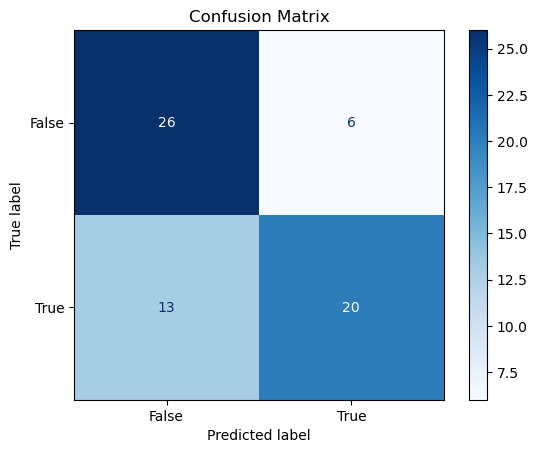


Accuracy: 0.7076923076923077
Classification Report:
              precision    recall  f1-score   support

       False       0.67      0.81      0.73        32
        True       0.77      0.61      0.68        33

    accuracy                           0.71        65
   macro avg       0.72      0.71      0.71        65
weighted avg       0.72      0.71      0.70        65



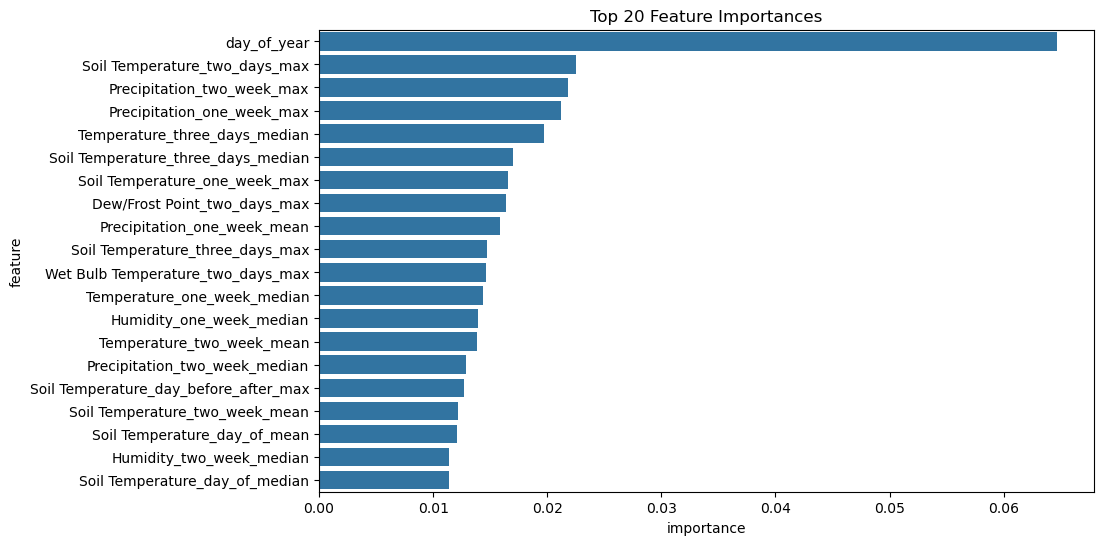

In [31]:
# Make predictions
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)

# Create and display confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix with labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                             display_labels=[False, True])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"\nAccuracy: {accuracy}")
print("Classification Report:")
print(report)

# Feature Importance
importances = rf_model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# Select top 20 features
top_20_features = feature_importance_df.head(20)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=top_20_features)
plt.title('Top 20 Feature Importances')
plt.show()



8. Compare Random Forest to other model options in scikitlearn. Which is the best?

Columns with missing values:
Temperature_day_of_mean              1
Temperature_day_of_min               1
Temperature_day_of_max               1
Temperature_day_of_median            1
Temperature_day_before_after_mean    1
                                    ..
Soil Temperature_one_week_median     1
Soil Temperature_two_week_mean       1
Soil Temperature_two_week_min        1
Soil Temperature_two_week_max        1
Soil Temperature_two_week_median     1
Length: 144, dtype: int64
Evaluating Random Forest...
Evaluating AdaBoost...
Evaluating Gradient Boosting...
Evaluating KNN...
Evaluating SVM...
Evaluating Decision Tree...

Model Comparison Results:
               Model  Accuracy    Recall  Precision  F1-score  CV Mean Score  \
3                KNN  0.738462  0.787879   0.722222  0.753623       0.654072   
2  Gradient Boosting  0.692308  0.787879   0.666667  0.722222       0.716214   
5      Decision Tree  0.692308  0.757576   0.675676  0.714286       0.700226   
0      Random Forest  

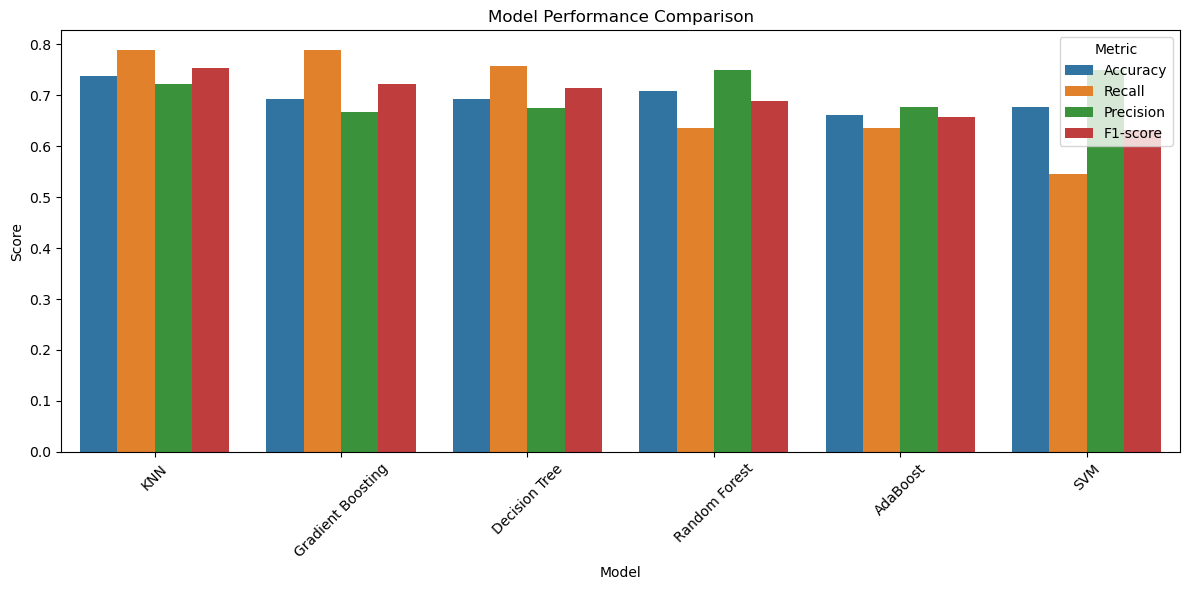


Best Model (prioritizing recall):
Model: KNN
Recall: 0.7879
Accuracy: 0.7385
F1-score: 0.7536

Detailed Classification Report for Best Model:
              precision    recall  f1-score   support

       False       0.76      0.69      0.72        32
        True       0.72      0.79      0.75        33

    accuracy                           0.74        65
   macro avg       0.74      0.74      0.74        65
weighted avg       0.74      0.74      0.74        65



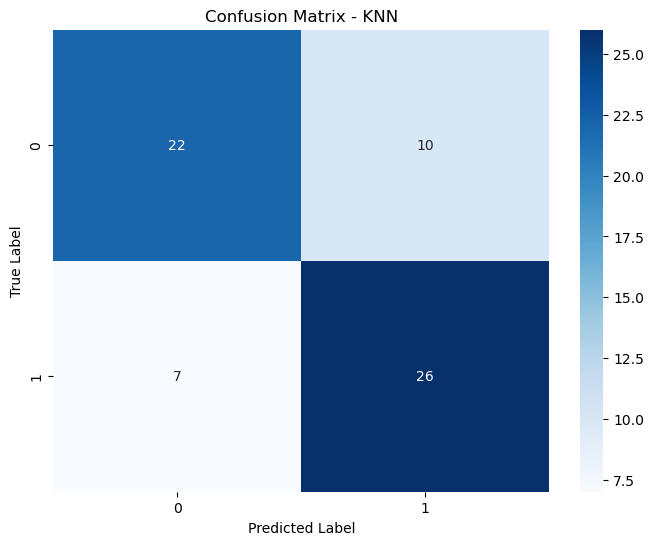

In [35]:
# Import additional models and metrics
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set environment variable to avoid KNN warning
os.environ["LOKY_MAX_CPU_COUNT"] = str(os.cpu_count())

# First, let's check where the NaN values are
print("Columns with missing values:")
print(X.isna().sum()[X.isna().sum() > 0])

# Define preprocessing and model evaluation pipeline
def create_pipeline(model):
    """
    Create a pipeline with preprocessing steps and the model.
    """
    return Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),  # Fill missing values with mean
        ('scaler', StandardScaler()),                 # Scale features
        ('model', model)
    ])

# Define a function to evaluate models
def evaluate_model(pipeline, X_train, X_test, y_train, y_test, model_name):
    """
    Evaluate a model using multiple metrics and cross-validation.
    
    Returns:
        dict: Dictionary containing all evaluation metrics
    """
    # Train the pipeline
    pipeline.fit(X_train, y_train)
    
    # Make predictions
    y_pred = pipeline.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Perform cross-validation
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5)
    
    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'Recall': recall,
        'Precision': precision,
        'F1-score': f1,
        'CV Mean Score': cv_scores.mean(),
        'CV Std Dev': cv_scores.std()
    }

# Define base models to test
base_models = {
    'Random Forest': RandomForestClassifier(n_estimators=300, max_depth=3, random_state=42),
    'AdaBoost': AdaBoostClassifier(
        n_estimators=300, 
        random_state=42,
        algorithm='SAMME'  # Changed from default SAMME.R to avoid deprecation warning
    ),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=300, random_state=42),
    'KNN': KNeighborsClassifier(
        n_neighbors=5,
        n_jobs=-1  # Use all available cores
    ),
    'SVM': SVC(kernel='rbf', random_state=42),
    'Decision Tree': DecisionTreeClassifier(max_depth=3, random_state=42)
}

# Create pipelines for each model
models = {name: create_pipeline(model) for name, model in base_models.items()}

# Prepare data (assuming X and y are already defined as before)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Evaluate all models
results = []
for name, pipeline in models.items():
    print(f"Evaluating {name}...")
    result = evaluate_model(pipeline, X_train, X_test, y_train, y_test, name)
    results.append(result)

# Convert results to DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by=['Recall', 'Accuracy'], ascending=False)

# Display results
print("\nModel Comparison Results:")
print("========================")
print(results_df)

# Visualize results
plt.figure(figsize=(12, 6))
metrics = ['Accuracy', 'Recall', 'Precision', 'F1-score']
results_df_plot = results_df.melt(id_vars=['Model'], 
                                 value_vars=metrics, 
                                 var_name='Metric', 
                                 value_name='Score')

sns.barplot(x='Model', y='Score', hue='Metric', data=results_df_plot)
plt.xticks(rotation=45)
plt.title('Model Performance Comparison')
plt.tight_layout()
plt.show()

# Find best model based on recall and accuracy
best_model_recall = results_df.iloc[0]
print("\nBest Model (prioritizing recall):")
print("================================")
print(f"Model: {best_model_recall['Model']}")
print(f"Recall: {best_model_recall['Recall']:.4f}")
print(f"Accuracy: {best_model_recall['Accuracy']:.4f}")
print(f"F1-score: {best_model_recall['F1-score']:.4f}")

# Detailed analysis of best model
best_model_name = best_model_recall['Model']
best_pipeline = models[best_model_name]
y_pred = best_pipeline.predict(X_test)

print("\nDetailed Classification Report for Best Model:")
print("===========================================")
print(classification_report(y_test, y_pred))

# Plot confusion matrix for best model
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# If the best model supports feature importance, plot it
best_model = best_pipeline.named_steps['model']
if hasattr(best_model, 'feature_importances_'):
    plt.figure(figsize=(10, 6))
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    })
    feature_importance = feature_importance.sort_values('importance', ascending=False)
    
    sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
    plt.title(f'Top 10 Feature Importance - {best_model_name}')
    plt.tight_layout()
    plt.show()


9. For this dataset, KNN is the best balance of accuracy and recall. Let's save it as a seperate model file.